In [75]:
import pandas as pd
import numpy as np
import os
import scipy
from scipy.interpolate import griddata
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.nn.functional import mse_loss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(f"Using device: {device}")

class Swish(nn.Module):
    def __init__(self, inplace=True):
        super(Swish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        if self.inplace:
            x.mul_(torch.sigmoid(x))
            return x
        else:
            return x * torch.sigmoid(x)


class NavierStokesPINN_U(torch.nn.Module):
    def __init__(self):
        super(NavierStokesPINN_U, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

class NavierStokesPINN_V(torch.nn.Module):
    def __init__(self):
        super(NavierStokesPINN_V, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

class NavierStokesPINN_P(torch.nn.Module):
    def __init__(self):
        super(NavierStokesPINN_P, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

Using device: cuda


In [77]:
#Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = torch.tensor(data[:, [0, 1, 5, 7]], dtype=torch.float32).to(device)
        self.targets = torch.tensor(data[:, [2, 3, 4]], dtype=torch.float32).to(device)


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [78]:
def initialize_models():
    # Move models to GPU
    model_1 = NavierStokesPINN_U().to(device)
    model_2 = NavierStokesPINN_V().to(device)
    model_3 = NavierStokesPINN_P().to(device)

    print(f"Model_1 is on: {next(model_1.parameters()).device}")
    print(f"Model_2 is on: {next(model_2.parameters()).device}")
    print(f"Model_3 is on: {next(model_3.parameters()).device}")


    optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
    optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
    optimizer_3 = optim.Adam(model_3.parameters(), lr=1e-3)

    return model_1, model_2, model_3, optimizer_1, optimizer_2, optimizer_3

In [79]:
def compute_distance(x, y, d, n):
    """Compute the minimum distance of (x, y) from the nearest circular post."""
    tilt = 0.4/n
    centers = [(0, 0), (0, 0.4), (0.4, tilt), (0.4, 0.4+tilt)]
    
    distances = torch.full_like(x, float("inf"))  # Initialize distances with large values

    for cx, cy in centers:
        r = d / 2
        distance_to_post = torch.sqrt((x - cx) ** 2 + (y - cy) ** 2) - r
        distances = torch.minimum(distances, distance_to_post)  # Take the minimum distance

    return torch.maximum(distances, torch.tensor(0.0))  # Set negative distances to zero

def criterion(x_batch, y_batch, model_1, model_2, model_3, mse_loss, rho=1.0, nu=0.01):
    """
    Computes the loss based on physics-based PDE constraints and data loss.

    Args:
    - x_batch: Input tensor (batch of input values)
    - y_batch: Target tensor (batch of true output values)
    - model_1, model_2, model_3: Neural network models for u, v, and p
    - mse_loss: MSE loss function
    - rho: Density parameter for PDE constraints
    - nu: Viscosity parameter for PDE constraints

    Returns:
    - Total loss: Sum of physics loss and data loss
    """
    # ✅ Ensure requires_grad is set BEFORE using x_batch in model

    # Compute model predictions inside criterion
    x_batch.requires_grad_()
    u = model_1(x_batch)
    v = model_2(x_batch)
    p = model_3(x_batch)
    #print(u.shape)
    u = u.view(len(u),-1)
    v = v.view(len(v),-1)
    p = p.view(len(p),-1)
    #print(u.shape)


    # Unpack inputs
    x, y, d, n = x_batch[:, 0:1], x_batch[:, 1:2], x_batch[:, 2:3], x_batch[:, 3:4]

    # Compute distance to the nearest circular post
    distances = compute_distance(x, y, d, n)
    u[distances == 0] = 0
    v[distances == 0] = 0
    v[x == 0] = 0  #inlet y velocity
    u_loss = mse_loss(u, y_batch[:, 0:1])
    v_loss = mse_loss(v, y_batch[:, 1:2])
    p_loss = mse_loss(p, y_batch[:, 2:3])


    # Compute data loss (MSE against target values)
    L_data = ( u_loss + v_loss * 20 + p_loss )


    return L_data, u_loss, v_loss, p_loss


In [80]:
def main():
    # Load dataset (modify file path accordingly)
    file_path = os.path.join(os.getcwd(), "combined_output_bcU.csv")

    # Load data using pandas and convert to NumPy array
    df = pd.read_csv(file_path)  
    data = df.to_numpy(dtype=np.float32)  # Convert to NumPy array
    
    dataset = CustomDataset(data)
    dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)

    # Initialize models and optimizers
    model_1, model_2, model_3, optimizer_1, optimizer_2, optimizer_3 = initialize_models()

    # Training loop
    num_epochs = 100
    mse_loss = nn.MSELoss()
    for epoch in range(num_epochs):
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            # ✅ Directly pass x_batch & y_batch; criterion will handle predictions
            loss, u_loss, v_loss, p_loss = criterion(x_batch, y_batch, model_1, model_2, model_3, mse_loss)
    
            # Zero gradients
            optimizer_1.zero_grad()
            optimizer_2.zero_grad()
            optimizer_3.zero_grad()
    
            # Backpropagation
            loss.backward()
    
            # Update weights
            optimizer_1.step()
            optimizer_2.step()
            optimizer_3.step()
    
        if epoch % 2 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}, ULoss: {u_loss.item():.6f}, VLoss: {v_loss.item():.6f}, PLoss: {p_loss.item():.6f},")

    return model_1, model_2, model_3

In [81]:
model_1, model_2, model_3, optimizer_1, optimizer_2, optimizer_3 = initialize_models()
# Load model parameters with `weights_only=True`

e_idx = 499
mode = "original"

model_1.load_state_dict(torch.load(f"models/{mode}/{mode}_1_epoch_{e_idx}.pth", weights_only=True))
model_2.load_state_dict(torch.load(f"models/{mode}/{mode}_2_epoch_{e_idx}.pth", weights_only=True))
model_3.load_state_dict(torch.load(f"models/{mode}/{mode}_3_epoch_{e_idx}.pth", weights_only=True))

# Set models to evaluation mode
model_1.eval()
model_2.eval()
model_3.eval()


Model_1 is on: cuda:0
Model_2 is on: cuda:0
Model_3 is on: cuda:0


NavierStokesPINN_P(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Swish()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Swish()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Swish()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [82]:
import pandas as pd
import torch
import numpy as np

# File path to a specific CSV file #f(d*0.4)_n_reynolds
file_path = "data/csv/W_0.6_8_1.csv"

# Load CSV file
df = pd.read_csv(file_path)

# Ensure the correct columns are selected for input
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d, N)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

# Convert to PyTorch tensor and move to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

# Define function to compute the minimum distance from the nearest circular post
def compute_distance(x, y, d, n):
    """Compute the minimum distance of (x, y) from the nearest circular post."""
    tilt = 0.4 / n
    centers = [(0, 0), (0, 0.4), (0.4, tilt), (0.4, 0.4 + tilt)]
    
    distances = torch.full_like(x, float("inf"))  # Initialize distances with large values

    for cx, cy in centers:
        r = d / 2
        distance_to_post = torch.sqrt((x - cx) ** 2 + (y - cy) ** 2) - r
        distances = torch.minimum(distances, distance_to_post)  # Take the minimum distance

    return torch.maximum(distances, torch.tensor(0.0, device=device))  # Set negative distances to zero

# Make predictions
with torch.no_grad():
    u_pred = model_1(input_tensor)
    v_pred = model_2(input_tensor)
    p_pred = model_3(input_tensor)

# Extract individual elements
x, y, d, n = input_tensor[:, 0], input_tensor[:, 1], input_tensor[:, 2], input_tensor[:, 3]

# Apply conditions
v_pred[x == 0] = 0  # If x = 0, set v_pred to zero
p_pred[x == 0.4] = 0
# Compute distance
distances = compute_distance(x, y, d, n)

# If distance is zero, set u and v to zero
mask = distances == 0
u_pred[mask] = 0
v_pred[mask] = 0

# Move predictions to CPU and convert to NumPy
u_pred = u_pred.cpu().numpy()
v_pred = v_pred.cpu().numpy()
p_pred = p_pred.cpu().numpy()

x_grid = input_data[:, 0].reshape(-1)
y_grid = input_data[:, 1].reshape(-1)
v_actual_grid = output_data[:, 1].reshape(-1)
v_pred_grid = v_pred.flatten()
u_actual_grid = output_data[:, 0].reshape(-1)
u_pred_grid = u_pred.flatten()
p_pred_grid = p_pred.flatten()

# Create a DataFrame
df = pd.DataFrame({
    'x': x_grid,
    'y': y_grid,
    'u': u_pred_grid,
    'v': v_pred_grid,
    'p': p_pred_grid
})

# Save to CSV
df.to_csv(f'results/{mode}/csv/test_{mode}_0.6_8_1.csv', index=False)

print("CSV file saved successfully!")

CSV file saved successfully!


In [83]:
x_grid.shape

(18000,)

In [84]:
import os
import pandas as pd
import torch
import numpy as np

# Folder path containing CSV files
folder_path = "data/csv"

# Define value ranges
first_values = np.arange(0.3, 0.7, 0.05)  # 0.25 to 0.7 with step 0.05
second_values = np.arange(3, 15, 1)  # 3 to 14

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_distance(x, y, d, n):
    """Compute the minimum distance of (x, y) from the nearest circular post."""
    tilt = 0.4 / n
    centers = [(0, 0), (0, 0.4), (0.4, tilt), (0.4, 0.4 + tilt)]
    distances = torch.full_like(x, float("inf"))  # Initialize with large values
    
    for cx, cy in centers:
        r = d / 2
        distance_to_post = torch.sqrt((x - cx) ** 2 + (y - cy) ** 2) - r
        distances = torch.minimum(distances, distance_to_post)
    
    return torch.maximum(distances, torch.tensor(0.0, device=device))  # Set negative distances to zero

# Iterate over all possible files
for first in first_values:
    for second in second_values:
        first_str = f"{first:.2f}".rstrip("0").rstrip(".")
        file_name = f"W_{first_str}_{second}_1.csv"
        file_path = os.path.join(folder_path, file_name)
        
        if os.path.exists(file_path):
            print(f"Processing {file_name}...")
            
            # Load CSV file
            df = pd.read_csv(file_path)
            
            # Extract input and output data
            input_data = df.iloc[:, [0, 1, 5, 7]].values  # (x, y, d, N)
            output_data = df.iloc[:, [2, 3, 4]].values  # (u, v, p)
            
            input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
            
            # Predict using trained models
            with torch.no_grad():
                u_pred = model_1(input_tensor)
                v_pred = model_2(input_tensor)
                p_pred = model_3(input_tensor)
            
            # Extract individual elements
            x, y, d, n = input_tensor[:, 0], input_tensor[:, 1], input_tensor[:, 2], input_tensor[:, 3]
            
            # Apply conditions
            v_pred[x == 0] = 0  # If x = 0, set v_pred to zero
            
            # Compute distance
            distances = compute_distance(x, y, d, n)
            
            # If distance is zero, set u and v to zero
            mask = distances == 0
            u_pred[mask] = 0
            v_pred[mask] = 0
            
            # Convert to NumPy
            u_pred = u_pred.cpu().numpy()
            v_pred = v_pred.cpu().numpy()
            p_pred = p_pred.cpu().numpy()
            
            # Prepare DataFrame for output
            df_output = pd.DataFrame({
                'x': input_data[:, 0],
                'y': input_data[:, 1],
                'u': u_pred.flatten(),
                'v': v_pred.flatten(),
                'p': p_pred.flatten()
            })
            
            # Save velocity output file
            output_file = f"test_{mode}_{first_str}_{second}_1.csv"
            output_path = os.path.join(fr"results\{mode}\csv", output_file)
            df_output.to_csv(output_path, index=False)
            print(f"Saved {output_file} successfully!")

print("Processing complete!")


Processing W_0.3_3_1.csv...


Saved test_original_0.3_3_1.csv successfully!
Processing W_0.3_4_1.csv...
Saved test_original_0.3_4_1.csv successfully!
Processing W_0.3_5_1.csv...
Saved test_original_0.3_5_1.csv successfully!
Processing W_0.3_6_1.csv...
Saved test_original_0.3_6_1.csv successfully!
Processing W_0.3_7_1.csv...
Saved test_original_0.3_7_1.csv successfully!
Processing W_0.3_8_1.csv...
Saved test_original_0.3_8_1.csv successfully!
Processing W_0.3_9_1.csv...
Saved test_original_0.3_9_1.csv successfully!
Processing W_0.3_10_1.csv...
Saved test_original_0.3_10_1.csv successfully!
Processing W_0.3_11_1.csv...
Saved test_original_0.3_11_1.csv successfully!
Processing W_0.3_12_1.csv...
Saved test_original_0.3_12_1.csv successfully!
Processing W_0.3_13_1.csv...
Saved test_original_0.3_13_1.csv successfully!
Processing W_0.3_14_1.csv...
Saved test_original_0.3_14_1.csv successfully!
Processing W_0.35_3_1.csv...
Saved test_original_0.35_3_1.csv successfully!
Processing W_0.35_4_1.csv...
Saved test_original_0.35_

In [85]:
import pandas as pd
import torch
import numpy as np

# File path
file_path = "data/csv/W_0.6_14_1.csv"
file_pat = f"results/{mode}/csv/test_{mode}_0.6_14_1.csv"
# Load CSV file
df = pd.read_csv(file_path)
dff = pd.read_csv(file_pat)

# Ensure the correct columns are selected for input
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d, N)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

# Ensure the correct columns are selected for input
input_dataf = dff.iloc[:, [0, 1]].values  # Selecting columns (x, y, d, N)
output_dataf = dff.iloc[:, [2, 3]].values  # Selecting columns (u, v, p)

x_grid = input_data[:, 0].reshape(-1)
y_grid = input_data[:, 1].reshape(-1)
v_actual_grid = output_data[:, 1].reshape(-1)
v_pred_grid = output_dataf[:, 1].reshape(-1)
u_actual_grid = output_data[:, 0].reshape(-1)
u_pred_grid = output_dataf[:, 0].reshape(-1)


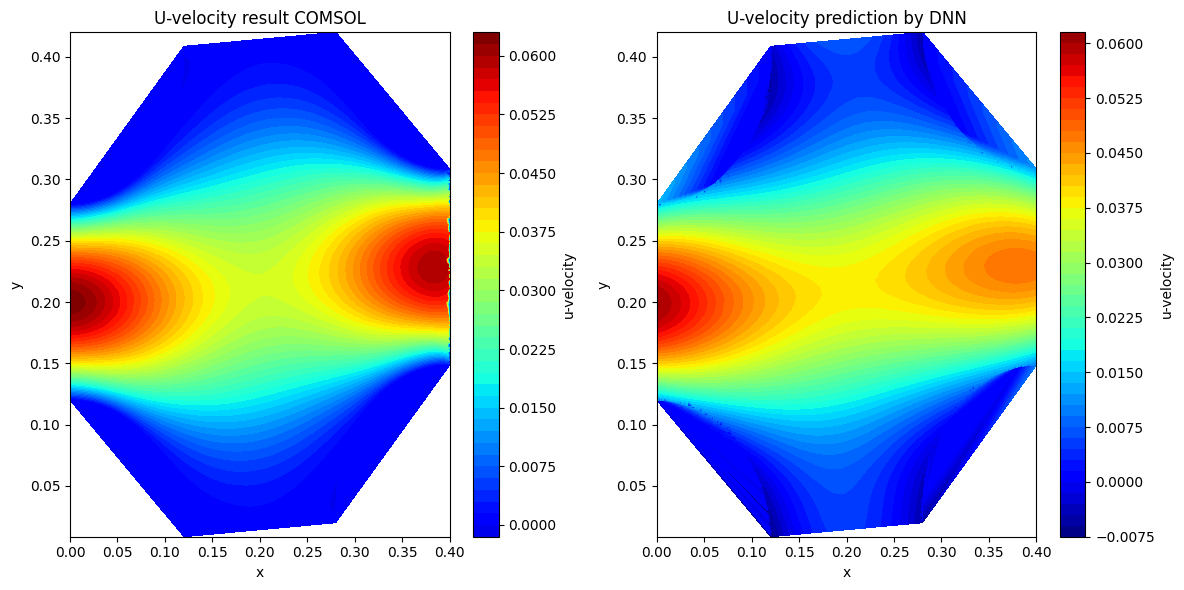

In [86]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(u_actual_grid.min(), u_pred_grid.min())
vmax = max(u_actual_grid.max(), u_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, u_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('U-velocity result COMSOL')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, u_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('U-velocity prediction by DNN')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/{mode}/PIDNN_U_{mode}_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()


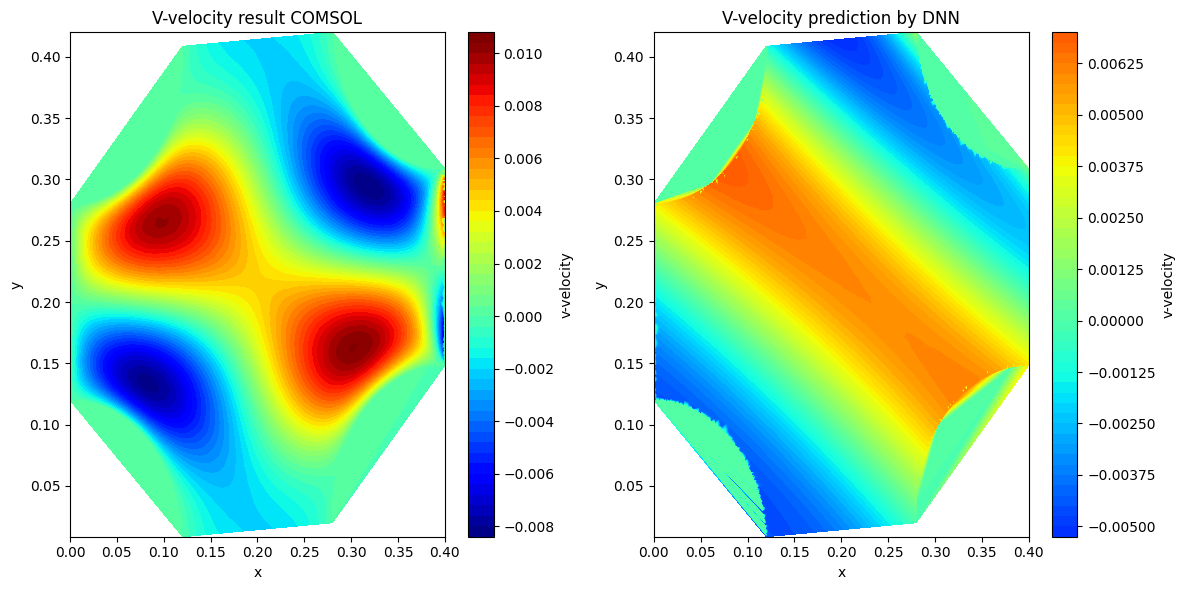

In [87]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='v-velocity')
plt.title('V-velocity result COMSOL')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='v-velocity')
plt.title('V-velocity prediction by DNN')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/{mode}/PIDNN_V_{mode}_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()


In [88]:
# Compute MSE using NumPy
mse_u = np.mean((v_pred_grid - v_actual_grid)**2)
print(f"Mean Squared Error for u-component: {mse_u}")

Mean Squared Error for u-component: 6.696576884289656e-06


In [89]:
# Compute MSE using NumPy
mse_u = np.mean((u_pred_grid - u_actual_grid)**2)
print(f"Mean Squared Error for u-component: {mse_u}")

Mean Squared Error for u-component: 5.244917072109368e-05
